In [24]:
# install: tqdm (progress bars)
!pip install tqdm
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


## Load the data (CIFAR-10)

In [2]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
train_dl = make_loader(TensorDataset(X_tr, Y_tr))
test_dl = make_loader(TensorDataset(X_te, Y_te))

0it [00:00, ?it/s]

100%|█████████▉| 169697280/170498071 [00:12<00:00, 15566759.81it/s]

Extracting ./data_cache/cifar-10-python.tar.gz to ./data_cache
Files already downloaded and verified


## Training helper functions

In [6]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

170500096it [02:13, 1274216.58it/s] 


In [7]:
## Define model

In [9]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [9]:
## Train

In [10]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 5.572 	 Train Acc: 0.156
	 [Batch 100 / 391] Train Loss: 3.926 	 Train Acc: 0.175
	 [Batch 150 / 391] Train Loss: 3.331 	 Train Acc: 0.195
	 [Batch 200 / 391] Train Loss: 3.009 	 Train Acc: 0.211
	 [Batch 250 / 391] Train Loss: 2.788 	 Train Acc: 0.227
	 [Batch 300 / 391] Train Loss: 2.627 	 Train Acc: 0.243
	 [Batch 350 / 391] Train Loss: 2.503 	 Train Acc: 0.258
Epoch 0:	 Train Loss: 2.420 	 Train Acc: 0.270	 Test Acc: 0.308
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.597 	 Train Acc: 0.408
	 [Batch 100 / 391] Train Loss: 1.592 	 Train Acc: 0.412
	 [Batch 150 / 391] Train Loss: 1.575 	 Train Acc: 0.418
	 [Batch 200 / 391] Train Loss: 1.552 	 Train Acc: 0.427
	 [Batch 250 / 391] Train Loss: 1.529 	 Train Acc: 0.437
	 [Batch 300 / 391] Train Loss: 1.506 	 Train Acc: 0.446
	 [Batch 350 / 391] Train Loss: 1.480 	 Train Acc: 0.459
Epoch 1:	 Train Loss: 1.466 	 Train Acc: 0.465	 Test Acc: 0.193
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.306 	 Train Acc: 0.527
	 [Batch 100 / 391] Train Loss: 1.274 	 Train Acc: 0.541
	 [Batch 150 / 391] Train Loss: 1.263 	 Train Acc: 0.546
	 [Batch 200 / 391] Train Loss: 1.244 	 Train Acc: 0.553
	 [Batch 250 / 391] Train Loss: 1.233 	 Train Acc: 0.559
	 [Batch 300 / 391] Train Loss: 1.216 	 Train Acc: 0.566
	 [Batch 350 / 391] Train Loss: 1.202 	 Train Acc: 0.570
Epoch 2:	 Train Loss: 1.192 	 Train Acc: 0.575	 Test Acc: 0.459
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.074 	 Train Acc: 0.612
	 [Batch 100 / 391] Train Loss: 1.051 	 Train Acc: 0.626
	 [Batch 150 / 391] Train Loss: 1.042 	 Train Acc: 0.629
	 [Batch 200 / 391] Train Loss: 1.036 	 Train Acc: 0.631
	 [Batch 250 / 391] Train Loss: 1.026 	 Train Acc: 0.636
	 [Batch 300 / 391] Train Loss: 1.012 	 Train Acc: 0.642
	 [Batch 350 / 391] Train Loss: 1.005 	 Train Acc: 0.644
Epoch 3:	 Train Loss: 0.999 	 Train Acc: 0.647	 Test Acc: 0.651
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.888 	 Train Acc: 0.693
	 [Batch 100 / 391] Train Loss: 0.880 	 Train Acc: 0.697
	 [Batch 150 / 391] Train Loss: 0.883 	 Train Acc: 0.693
	 [Batch 200 / 391] Train Loss: 0.879 	 Train Acc: 0.695
	 [Batch 250 / 391] Train Loss: 0.875 	 Train Acc: 0.697
	 [Batch 300 / 391] Train Loss: 0.868 	 Train Acc: 0.699
	 [Batch 350 / 391] Train Loss: 0.860 	 Train Acc: 0.701
Epoch 4:	 Train Loss: 0.853 	 Train Acc: 0.704	 Test Acc: 0.614
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.763 	 Train Acc: 0.734
	 [Batch 100 / 391] Train Loss: 0.780 	 Train Acc: 0.730
	 [Batch 150 / 391] Train Loss: 0.777 	 Train Acc: 0.730
	 [Batch 200 / 391] Train Loss: 0.769 	 Train Acc: 0.734
	 [Batch 250 / 391] Train Loss: 0.759 	 Train Acc: 0.736
	 [Batch 300 / 391] Train Loss: 0.752 	 Train Acc: 0.739
	 [Batch 350 / 391] Train Loss: 0.751 	 Train Acc: 0.741
Epoch 5:	 Train Loss: 0.743 	 Train Acc: 0.744	 Test Acc: 0.740
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.650 	 Train Acc: 0.781
	 [Batch 100 / 391] Train Loss: 0.657 	 Train Acc: 0.776
	 [Batch 150 / 391] Train Loss: 0.651 	 Train Acc: 0.777
	 [Batch 200 / 391] Train Loss: 0.643 	 Train Acc: 0.779
	 [Batch 250 / 391] Train Loss: 0.647 	 Train Acc: 0.777
	 [Batch 300 / 391] Train Loss: 0.642 	 Train Acc: 0.779
	 [Batch 350 / 391] Train Loss: 0.641 	 Train Acc: 0.779
Epoch 6:	 Train Loss: 0.644 	 Train Acc: 0.778	 Test Acc: 0.744
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.577 	 Train Acc: 0.803
	 [Batch 100 / 391] Train Loss: 0.565 	 Train Acc: 0.804
	 [Batch 150 / 391] Train Loss: 0.569 	 Train Acc: 0.805
	 [Batch 200 / 391] Train Loss: 0.570 	 Train Acc: 0.805
	 [Batch 250 / 391] Train Loss: 0.569 	 Train Acc: 0.805
	 [Batch 300 / 391] Train Loss: 0.570 	 Train Acc: 0.805
	 [Batch 350 / 391] Train Loss: 0.574 	 Train Acc: 0.804
Epoch 7:	 Train Loss: 0.572 	 Train Acc: 0.805	 Test Acc: 0.764
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.472 	 Train Acc: 0.837
	 [Batch 100 / 391] Train Loss: 0.488 	 Train Acc: 0.832
	 [Batch 150 / 391] Train Loss: 0.497 	 Train Acc: 0.828
	 [Batch 200 / 391] Train Loss: 0.494 	 Train Acc: 0.829
	 [Batch 250 / 391] Train Loss: 0.488 	 Train Acc: 0.832
	 [Batch 300 / 391] Train Loss: 0.488 	 Train Acc: 0.833
	 [Batch 350 / 391] Train Loss: 0.492 	 Train Acc: 0.832
Epoch 8:	 Train Loss: 0.492 	 Train Acc: 0.831	 Test Acc: 0.706
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.400 	 Train Acc: 0.868
	 [Batch 100 / 391] Train Loss: 0.414 	 Train Acc: 0.861
	 [Batch 150 / 391] Train Loss: 0.406 	 Train Acc: 0.863
	 [Batch 200 / 391] Train Loss: 0.410 	 Train Acc: 0.862
	 [Batch 250 / 391] Train Loss: 0.423 	 Train Acc: 0.859
	 [Batch 300 / 391] Train Loss: 0.424 	 Train Acc: 0.858
	 [Batch 350 / 391] Train Loss: 0.428 	 Train Acc: 0.857
Epoch 9:	 Train Loss: 0.433 	 Train Acc: 0.854	 Test Acc: 0.752
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.340 	 Train Acc: 0.885
	 [Batch 100 / 391] Train Loss: 0.368 	 Train Acc: 0.881
	 [Batch 150 / 391] Train Loss: 0.366 	 Train Acc: 0.880
	 [Batch 200 / 391] Train Loss: 0.361 	 Train Acc: 0.881
	 [Batch 250 / 391] Train Loss: 0.358 	 Train Acc: 0.881
	 [Batch 300 / 391] Train Loss: 0.362 	 Train Acc: 0.880
	 [Batch 350 / 391] Train Loss: 0.370 	 Train Acc: 0.877
Epoch 10:	 Train Loss: 0.371 	 Train Acc: 0.877	 Test Acc: 0.782
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.277 	 Train Acc: 0.908
	 [Batch 100 / 391] Train Loss: 0.299 	 Train Acc: 0.905
	 [Batch 150 / 391] Train Loss: 0.342 	 Train Acc: 0.898
	 [Batch 200 / 391] Train Loss: 0.330 	 Train Acc: 0.898
	 [Batch 250 / 391] Train Loss: 0.323 	 Train Acc: 0.899
	 [Batch 300 / 391] Train Loss: 0.321 	 Train Acc: 0.898
	 [Batch 350 / 391] Train Loss: 0.322 	 Train Acc: 0.897
Epoch 11:	 Train Loss: 0.324 	 Train Acc: 0.896	 Test Acc: 0.791
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.218 	 Train Acc: 0.928
	 [Batch 100 / 391] Train Loss: 0.239 	 Train Acc: 0.922
	 [Batch 150 / 391] Train Loss: 0.240 	 Train Acc: 0.921
	 [Batch 200 / 391] Train Loss: 0.238 	 Train Acc: 0.921
	 [Batch 250 / 391] Train Loss: 0.252 	 Train Acc: 0.920
	 [Batch 300 / 391] Train Loss: 0.251 	 Train Acc: 0.919
	 [Batch 350 / 391] Train Loss: 0.263 	 Train Acc: 0.916
Epoch 12:	 Train Loss: 0.262 	 Train Acc: 0.916	 Test Acc: 0.799
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.134 	 Train Acc: 0.956
	 [Batch 100 / 391] Train Loss: 0.140 	 Train Acc: 0.955
	 [Batch 150 / 391] Train Loss: 0.161 	 Train Acc: 0.948
	 [Batch 200 / 391] Train Loss: 0.171 	 Train Acc: 0.945
	 [Batch 250 / 391] Train Loss: 0.171 	 Train Acc: 0.945
	 [Batch 300 / 391] Train Loss: 0.181 	 Train Acc: 0.943
	 [Batch 350 / 391] Train Loss: 0.190 	 Train Acc: 0.940
Epoch 13:	 Train Loss: 0.191 	 Train Acc: 0.940	 Test Acc: 0.817
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.087 	 Train Acc: 0.975
	 [Batch 100 / 391] Train Loss: 0.082 	 Train Acc: 0.977
	 [Batch 150 / 391] Train Loss: 0.104 	 Train Acc: 0.969
	 [Batch 200 / 391] Train Loss: 0.109 	 Train Acc: 0.968
	 [Batch 250 / 391] Train Loss: 0.132 	 Train Acc: 0.965
	 [Batch 300 / 391] Train Loss: 0.128 	 Train Acc: 0.965
	 [Batch 350 / 391] Train Loss: 0.140 	 Train Acc: 0.962
Epoch 14:	 Train Loss: 0.138 	 Train Acc: 0.962	 Test Acc: 0.770
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.051 	 Train Acc: 0.987
	 [Batch 100 / 391] Train Loss: 0.045 	 Train Acc: 0.990
	 [Batch 150 / 391] Train Loss: 0.043 	 Train Acc: 0.990
	 [Batch 200 / 391] Train Loss: 0.042 	 Train Acc: 0.990
	 [Batch 250 / 391] Train Loss: 0.070 	 Train Acc: 0.984
	 [Batch 300 / 391] Train Loss: 0.070 	 Train Acc: 0.983
	 [Batch 350 / 391] Train Loss: 0.073 	 Train Acc: 0.982
Epoch 15:	 Train Loss: 0.083 	 Train Acc: 0.980	 Test Acc: 0.787
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.031 	 Train Acc: 0.995
	 [Batch 100 / 391] Train Loss: 0.026 	 Train Acc: 0.997
	 [Batch 150 / 391] Train Loss: 0.024 	 Train Acc: 0.997
	 [Batch 200 / 391] Train Loss: 0.023 	 Train Acc: 0.997
	 [Batch 250 / 391] Train Loss: 0.023 	 Train Acc: 0.997
	 [Batch 300 / 391] Train Loss: 0.023 	 Train Acc: 0.997
	 [Batch 350 / 391] Train Loss: 0.023 	 Train Acc: 0.997
Epoch 16:	 Train Loss: 0.022 	 Train Acc: 0.997	 Test Acc: 0.855
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.008 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.008 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.008 	 Train Acc: 0.999	 Test Acc: 0.851
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.004 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.004 	 Train Acc: 1.000	 Test Acc: 0.857
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.859


### Flipped images

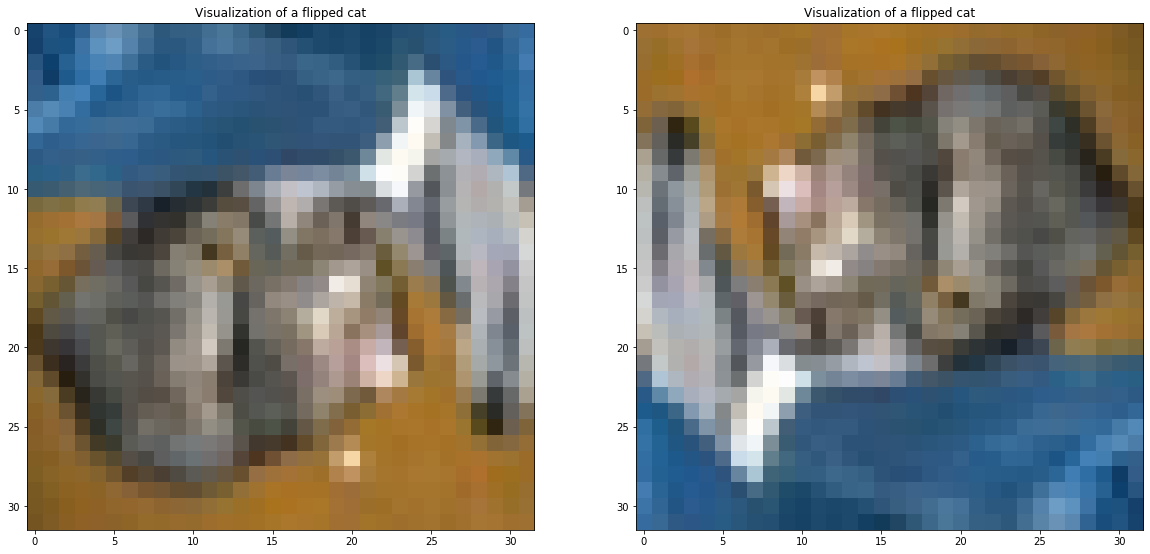

In [39]:
X_te_flipped = torch.flip(X_te, [2, 3])
non_flipped_cat = X_te[Y_te == 3][0]
flipped_cat = X_te_flipped[Y_te == 3][0]
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].imshow(flipped_cat.permute((1, 2, 0)))
axes[0].set_title('Visualization of a flipped cat')
axes[1].imshow(non_flipped_cat.permute((1, 2, 0)))
axes[1].set_title('Visualization of a flipped cat')
plt.show(fig)